In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools
from permacache import stable_hash

In [4]:
from evallm.experiments.transducer_experiment import (
    current_transducer_experiments,
    compute_relative_to_null,
    compute_relative_to_ngram,
    plot_relative_results,
    print_example,
    bottom_quartile_outcome,
    plot_all_absolute_results,
    plot_all_absolute_results_single_graph,
)

In [5]:
from evallm.prompting.transducer_prompt import (
    ChainOfThoughtPromptRealExampleNoExplanation,
    BasicSequencePrompt,
)

In [6]:
# cot = ChainOfThoughtPromptRealExampleNoExplanation(
#     30, dict(type="sample_reachable_dfa", n_states=3, n_symbols=3), 1
# )

In [7]:
# from evallm.sample_dfa.sample_dfa import sample_dfa

# dfa = sample_dfa(
#     dict(type="sample_reachable_dfa", n_states=3, n_symbols=3), np.random.RandomState(0)
# )
# dfa

In [8]:
# print(cot.prompt_and_answer(dfa, np.random.RandomState(0), is_chat=True)[1]["user"])

In [9]:
basic_sequence_prompt = (
    lambda num_sequence_symbols, sample_dfa_spec: BasicSequencePrompt(
        num_sequence_symbols, version=3
    )
)

In [10]:
results = {
    "llama3-8B": current_transducer_experiments(
        "meta-llama/Meta-Llama-3-8B",
        num_states_options=(3,),
        num_dfas=30,
        num_sequence_symbol_options=(30, 60, 90, 120, 180, 240, 300, 400, 500),
    ),
    "gpt-35-nonchat": current_transducer_experiments(
        "gpt-3.5-turbo-instruct",
        num_dfas=30,
        num_states_options=(3,),
        num_sequence_symbol_options=(30, 120, 240, 300, 400),
    ),
    "gpt-4o-mini + just seq": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=basic_sequence_prompt,
        num_states_options=(3,),
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o + just seq": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-2024-05-13",
        cot_prompt=basic_sequence_prompt,
        num_states_options=(3,),
        num_sequence_symbol_options=(30, 120, 240, 500),
        allow_expensive=True,
    ),
}

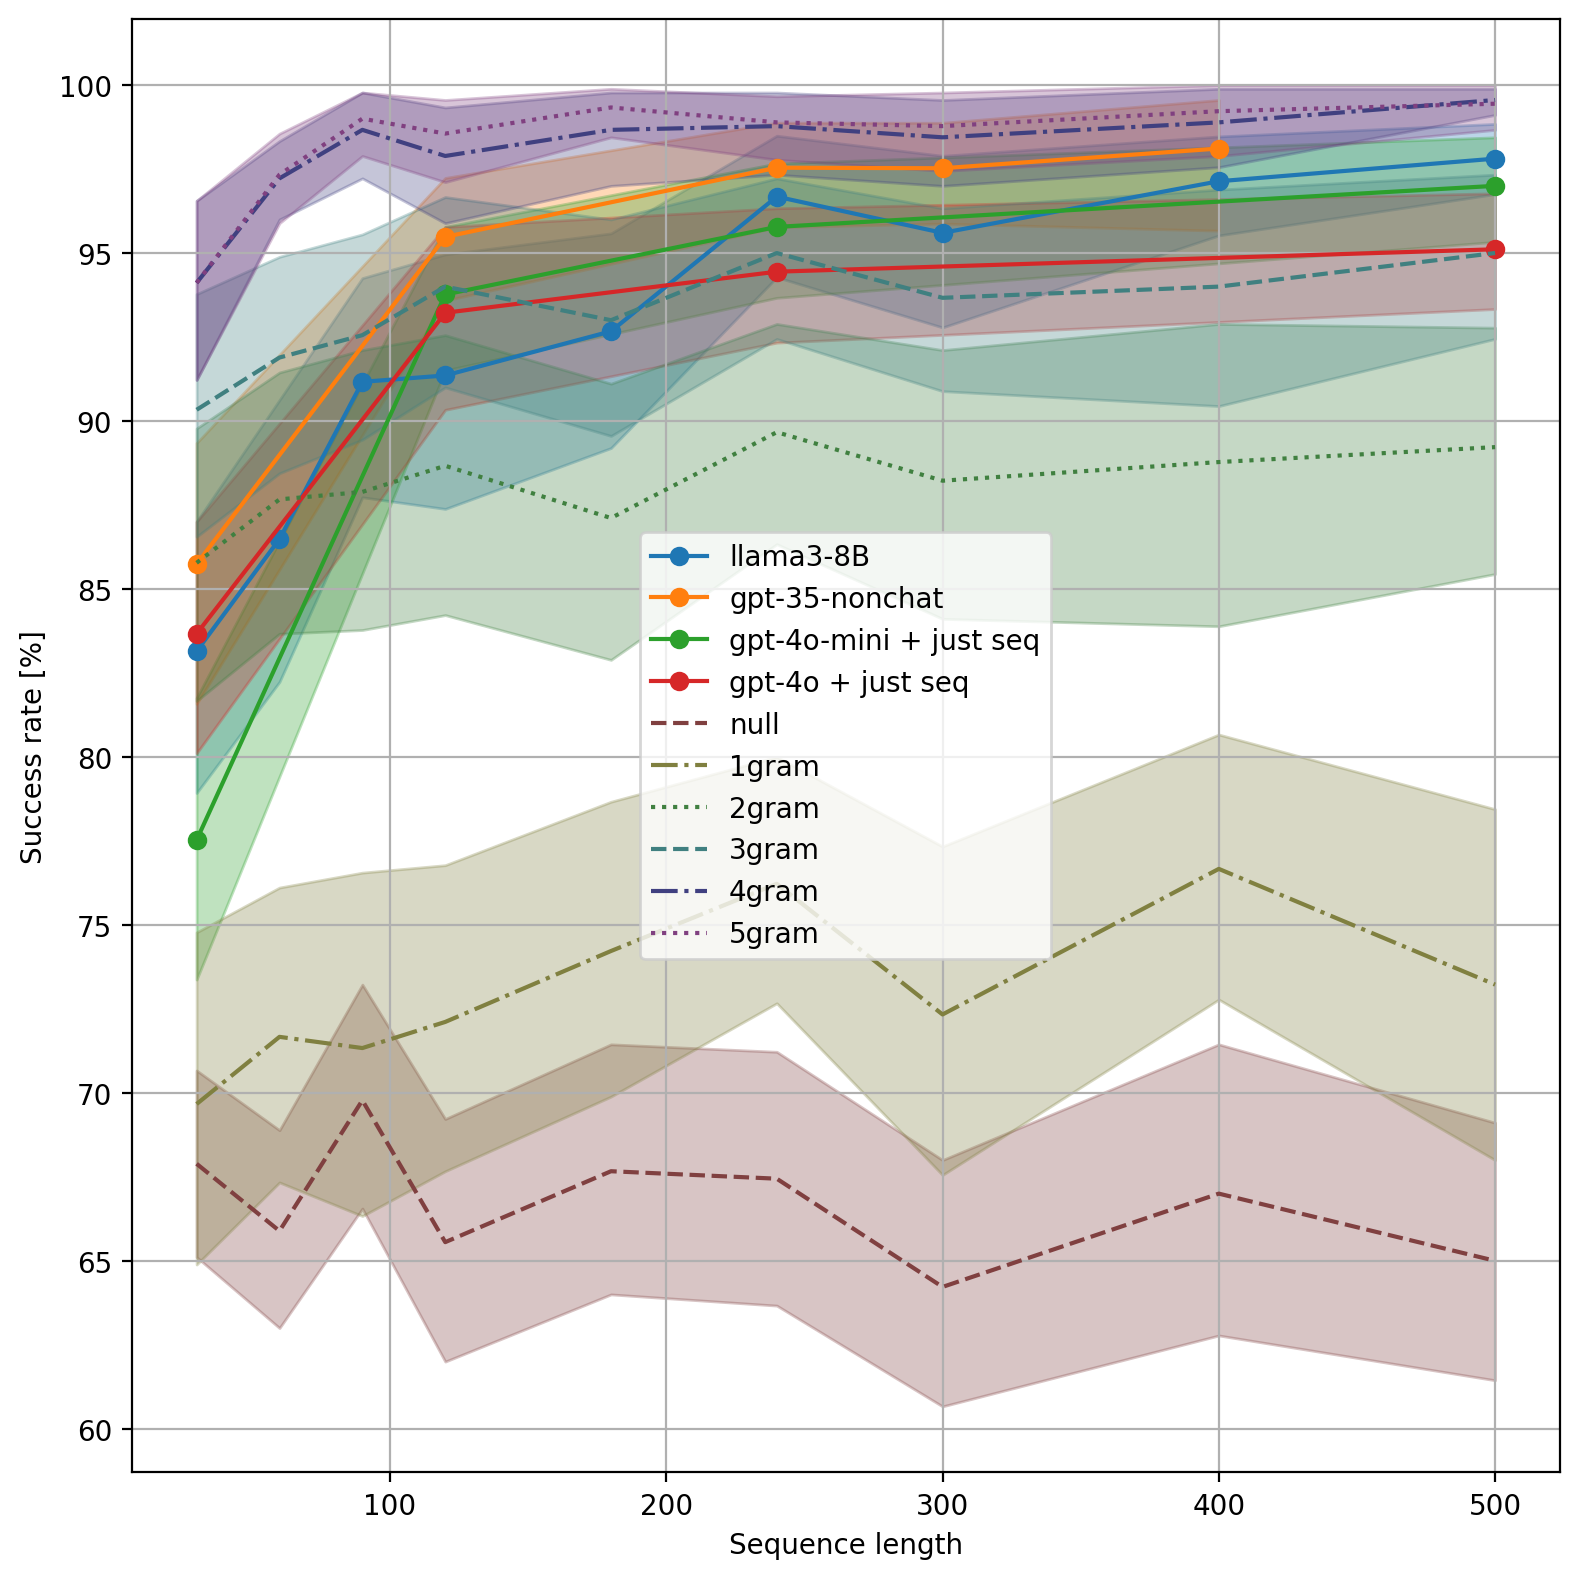

In [11]:
plot_all_absolute_results_single_graph(results, 3, ignore_na=True)

In [12]:
# plot_all_absolute_results(results, 5, ignore_na=True)

In [13]:
# plot_all_absolute_results(results, 7, ignore_na=True)

In [14]:
prompter = evallm.prompting.transducer_prompt.ChainOfThoughtPrompt(30)

In [15]:
# print_example(
#     "gpt-3.5-turbo-0125", prompter, bottom_quartile_outcome(results["gpt-3.5"][3][30])
# )

In [16]:
# print_example(
#     "gpt-4o-mini-2024-07-18",
#     prompter,
#     bottom_quartile_outcome(results["gpt-4o-mini"][3][30]),
# )

In [17]:
prompter_basic = evallm.prompting.transducer_prompt.BasicSequencePrompt(30, version=3)

In [18]:
u = results["gpt-4o-mini + just seq"][3][30]
print_example(
    "gpt-4o-mini-2024-07-18",
    prompter_basic,
    bottom_quartile_outcome(u),
)

********* EXAMPLE 0: WRONG ***********
######### SYSTEM ############

######### USER ############
You are a sequence completion model. Output the next element of the sequence, and nothing else.

b, 1, b, 0, a, 0, c, 0, c, 0, c, 0, c, 0, b, 0, b, 1, c, 0, b, 1, c, 0, b, 1, b, 0, b, 1, a, 1, b, 0, b, 1, c, 0, c, 1, c, 0, a, 0, c, 0, b, 0, b, 1, a, 1, c, 0, c, 1, b, 0, a, 
######### RESPONSE: WRONG ############
1

********* EXAMPLE 1: CORRECT ***********
######### SYSTEM ############

######### USER ############
You are a sequence completion model. Output the next element of the sequence, and nothing else.

b, 1, a, 1, c, 0, c, 1, a, 1, b, 0, c, 1, c, 0, c, 1, b, 0, a, 0, b, 0, a, 0, a, 0, a, 0, a, 0, b, 0, c, 1, a, 1, a, 1, b, 0, b, 1, a, 1, b, 0, a, 0, b, 0, b, 1, a, 1, b, 0, c, 
######### RESPONSE: CORRECT ############
1

********* EXAMPLE 2: WRONG ***********
######### SYSTEM ############

######### USER ############
You are a sequence completion model. Output the next element of the 